# Introduction to Machine Learning with Python

The aim of this first part is to provide a little introduction to Python, and especially on how to learn a model, i.e., split the data into training/testing and how we can tune a hyper parameter associated to an optimization problem or to a model

$$\underset{h\in \mathcal{H}}{\min} \; \dfrac{1}{m}\sum_{i=1}^m \ell(h({\bf x}_i,y_i) + \lambda \Vert h \Vert$$.

We can first start with the different packages that we will need for this procedure and we are going to use a simple algorithm which is called the k-NN for an illustration of the procedure.

In [12]:
# We first load some libraries that will useful for the study

# To manipulate data and some basic packages
import random
import sys
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
# Can be used to split the dataset, learn the model and tune hyper parameters.
# In other words, to prepare the learning preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, validation_curve
from sklearn.preprocessing import Normalizer
# Some libraries to compute the performance score of a model
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
# Finally, the following are used to learn a model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text


np.set_printoptions(legacy='1.25')

We first load the dataset we are going to use for this task. It is a classification task where the aim is to predict if the studied individual has a diabete or not (outcome = 1 or 0) given the other features.

In [ ]:
df = pd.read_csv("datasets/diabete.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We seperate the features (X) from the label (Y) which is going to be useful for the remaining part of the study


In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)


We are going to learn our k-Nearest Neighbor algorithm on a training datset and study its performances on a test dataset.
First, we need to split the data into a training set and a test set.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True,
                                                stratify=y, test_size=0.2)

We can now learn the model.
The used algorithm depends on a hyper-parameter which is the number of neighbors $k$.
In the following, the value will be set to $3$.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(Xtrain, ytrain)
predict_train = clf.predict(Xtrain)
predict_test = clf.predict(Xtest)



In [ ]:
print("On the training set")
print(classification_report(ytrain, predict_train))
print("On the test set")
print(classification_report(ytest, predict_test))


On the training set
              precision    recall  f1-score   support

           0       0.84      0.91      0.88       400
           1       0.80      0.68      0.74       214

    accuracy                           0.83       614
   macro avg       0.82      0.80      0.81       614
weighted avg       0.83      0.83      0.83       614

On the test set
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       100
           1       0.57      0.63      0.60        54

    accuracy                           0.70       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.70      0.70       154



In [ ]:
def applyAlgo(algo,hyper, Xtrain, ytrain, Xtest, ytest):
  if algo == "knn":
    clf = KNeighborsClassifier(n_neighbors=hyper)
    clf.fit(Xtrain, ytrain)
    predict_train = clf.predict(Xtrain)
    predict_test = clf.predict(Xtest)

    ctrain = confusion_matrix(ytrain, predict_train)
    score_train = round((ctrain[0,0]+ctrain[1,1])/Xtrain.shape[0],4)
    ctest = confusion_matrix(ytest, predict_test)
    score_test = round((ctest[0,0]+ctest[1,1])/Xtest.shape[0],4)

    return (round(score_train*100,2), round(score_test*100,2))

We can try to cross-validate the hyper-parameter $k$.
We will first do it by hand, just to do illustrate what has been presented in class.

In [ ]:
# Create a dictionnary where we are going to sotck the results.
results = {}
# List of possible values for k and number of folds
list_k = [3,5,7,9,11,13,15,17]
nbFoldValid = 5


skf = StratifiedKFold(n_splits=nbFoldValid, shuffle=True) # initialisation CV
foldsTrainValid = list(skf.split(Xtrain, ytrain)) # create the groups

# Information on the dataset and used algorithm
dataset = 'diabete'
algo = 'knn'

results[dataset] = {}


# Start Cross-Validation
validParam = [] # We stock the mean values associated to each parameter value
for param in list_k: # For all possible values of k
  valid = [] # store the validation scores associated to each k value.
  for iFoldVal in range(nbFoldValid):
      fTrain, fValid = foldsTrainValid[iFoldVal] # definition of the validation folds
      # Apply the algorithm
      res = applyAlgo(algo, param,
                              Xtrain.iloc[fTrain], ytrain.iloc[fTrain],
                              Xtrain.iloc[fValid], ytrain.iloc[fValid])
      valid.append(res[1])
  # Store the results
  validParam.append(np.mean(valid))
  param = list_k[np.argmax(validParam)]
  score_Train, score_Test = applyAlgo(algo, param, Xtrain, ytrain, Xtest, ytest)
  results[dataset][algo] = (score_Train, score_Test)


print(param)
print(results)

17
{'diabete': {'knn': (76.06, 75.97)}}


We can try to check if the validation procedure that is applied is a good thing or not.  

In [ ]:
res_train = []
res_test = []
for param in list_k:
  res_train.append(applyAlgo(algo, param, Xtrain, ytrain, Xtrain, ytrain)[0])
  res_test.append(applyAlgo(algo, param, Xtrain, ytrain, Xtest, ytest)[1])

print(res_train)
print(res_test)


[82.57, 79.97, 77.04, 77.04, 76.55, 76.06, 75.9, 76.06]
[70.13, 70.13, 72.73, 76.62, 75.32, 75.32, 75.32, 75.97]


We will then graphically represent the results on the same graph. The red curve is used for the train accuracy and the blue curve for the test accuracy.

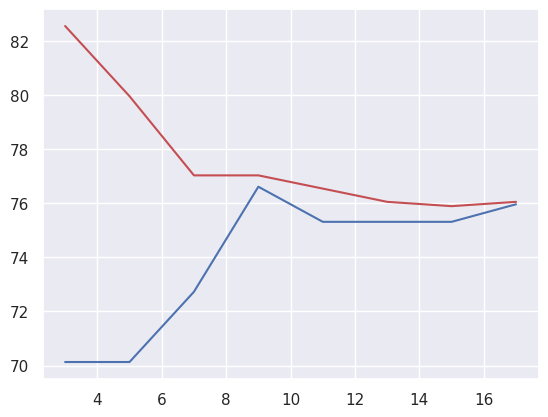

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list_k, res_train, 'r', list_k, res_test, 'b')
plt.show()


## Classification Tree

We now repeat the same process with the classification tree algorithm.
Such a model is learned as follows


In [ ]:
clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)
predict_train = clf.predict(Xtrain)
predict_test = clf.predict(Xtest)

print(classification_report(ytest, predict_test))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       100
           1       0.48      0.46      0.47        54

    accuracy                           0.64       154
   macro avg       0.60      0.60      0.60       154
weighted avg       0.63      0.64      0.63       154



The classification tree algorithm depends on several parameters that can be used to improve its performance.
Using the code provided before might be very hard to implement in practise if you do not feel comfortable with coding.
We are going to use another function python which is called *GridSearchCV* which is going to perform the crossvalidation for us.

Let us first have a look at the different hyper parameters link to this algorithm.

In [ ]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

There are lots of hyper parameters in this algorithm that can be tuned but we will just focus on some them such as the *max_depth* of the tree and the *min_sample_split* (for instance).

In [ ]:
clf_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

We are going to perform a 5-folds croww validation again and on the same dataset.



In [ ]:
clf_best_grid = GridSearchCV(clf,
                              clf_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=True).fit(Xtrain, ytrain)

print(clf_best_grid.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 5, 'min_samples_split': 16}


We can now use this set of hyper-parameters to learn a model and evaluate it on a test data (Xtest)

In [ ]:
clf_final = DecisionTreeClassifier(**clf_best_grid.best_params_).fit(Xtrain, ytrain)
predict_test = clf_final.predict(Xtest)
print(classification_report(ytest, predict_test))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79       100
           1       0.60      0.39      0.47        54

    accuracy                           0.69       154
   macro avg       0.66      0.62      0.63       154
weighted avg       0.68      0.69      0.68       154



For such a model, it can also be interesting to detect which information were very important to take th final decision.
You can do it using the following lines of code.

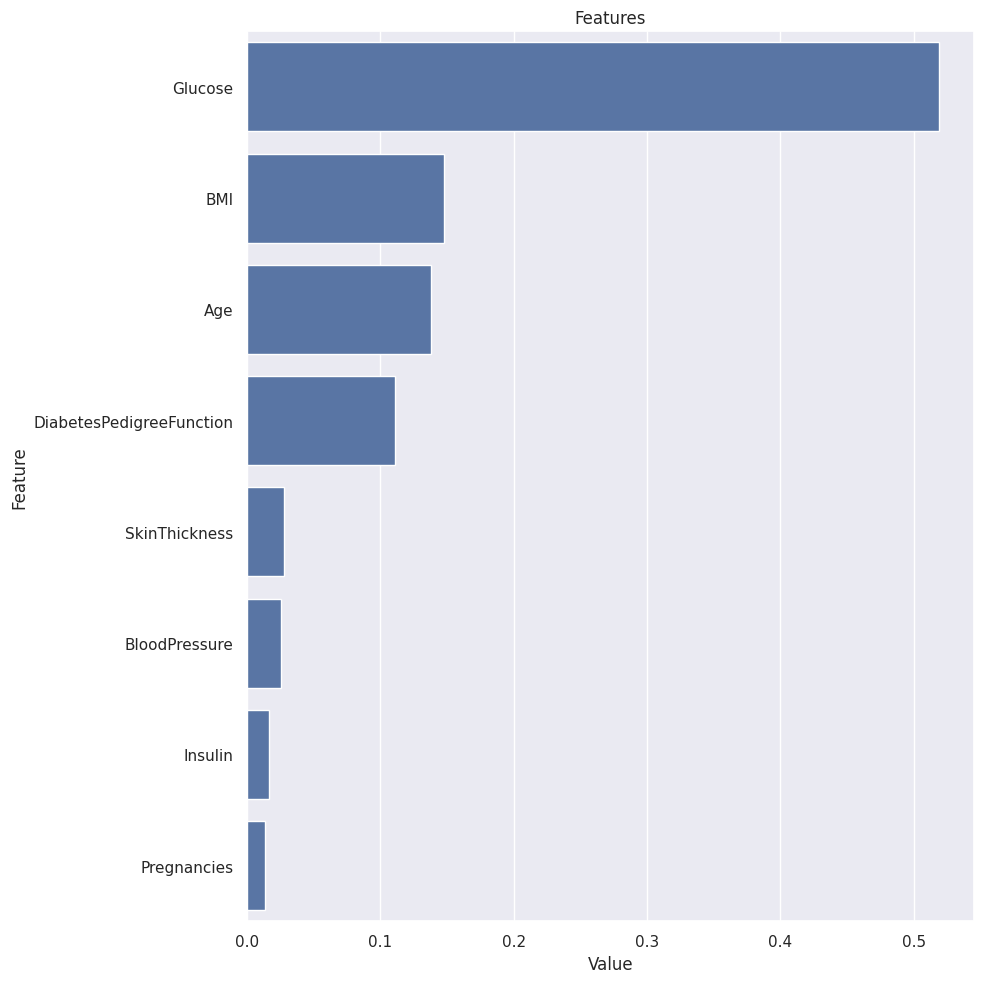

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(clf_final, X, 15)

You can also try to analyze the performance results with respect to the depth of the tree and study what happen.

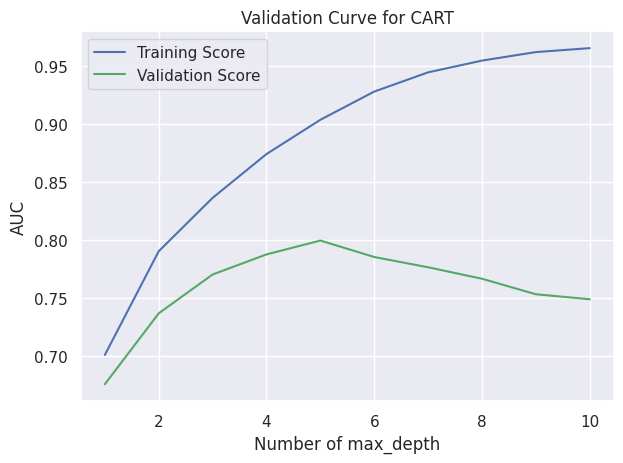

In [ ]:
train_score, test_score = validation_curve(
    clf_final, X=X, y=y,
    param_name='max_depth',
    param_range=range(1, 11),
    scoring="roc_auc",
    cv=5)

mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)

plt.plot(range(1, 11), mean_train_score,
         label="Training Score", color='b')
plt.plot(range(1, 11), mean_test_score,
         label="Validation Score", color='g')

plt.title("Validation Curve for CART")
plt.xlabel("Number of max_depth")
plt.ylabel("AUC")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

Let us see the boundaries of the classification tree using only a subset of the variables. For this purpose, we are going to use only the two first features of our dataset.


In [ ]:
X_short = X[['Pregnancies','Glucose']]
Xtrain, Xtest, ytrain, ytest = train_test_split(X_short, y, shuffle=True,
                                                stratify=y, test_size=0.2)

clf = DecisionTreeClassifier()
clf.fit(Xtrain, ytrain)
predict_test = clf.predict(Xtest)
print(classification_report(ytest, predict_test))



              precision    recall  f1-score   support

           0       0.78      0.65      0.71       100
           1       0.51      0.67      0.58        54

    accuracy                           0.66       154
   macro avg       0.65      0.66      0.64       154
weighted avg       0.69      0.66      0.66       154



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


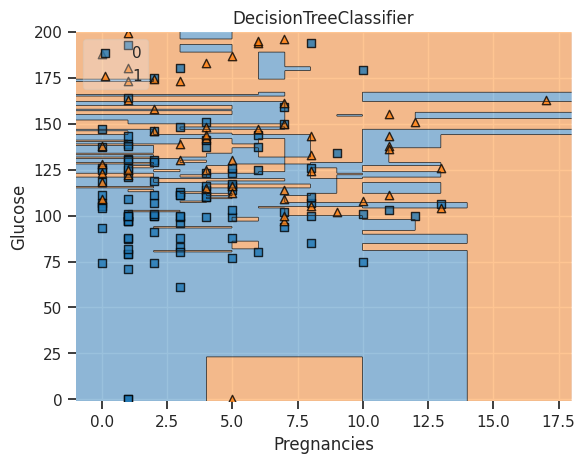

In [ ]:
import mlxtend.plotting
def plot_labeled_decision_regions(Xtest, ytest, clf):

    mlxtend.plotting.plot_decision_regions(np.array(Xtest), np.array(ytest), clf=clf, legend=2)

    # Adding axes annotations
    plt.xlabel(Xtest.columns[0])
    plt.ylabel(Xtest.columns[1])
    plt.title(str(clf).split('(')[0])
    plt.show()

plot_labeled_decision_regions(Xtest, ytest, clf)

## Regression Tree

Regression trees work a little bit differently since the label at the end is no more an integer but a real number.

In [ ]:
auto= pd.read_csv('datasets/auto.csv')
auto_origin = pd.get_dummies(auto.origin,dtype=int)
auto = pd.concat([auto, auto_origin], axis = 1).drop('origin', axis = 1)
auto.columns = ['mpg', 'displ', 'hp', 'weight', 'accel', 'size', 'origin_Asia', 'origin_Europe', 'origin_US']
auto.head()

,mpg,displ,hp,weight,accel,size,origin_Asia,origin_Europe,origin_US
0,18.0,250.0,88,3139,14.5,15.0,0,0,1
1,9.0,304.0,193,4732,18.5,20.0,0,0,1
2,36.1,91.0,60,1800,16.4,10.0,1,0,0
3,18.5,250.0,98,3525,19.0,15.0,0,0,1
4,34.3,97.0,78,2188,15.8,10.0,0,1,0


In [ ]:
y = auto["mpg"]
X = auto.drop(["mpg"], axis=1)

We now want to do a regression tree. We need to import the required library dnd we split our data again.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True,
                                                stratify=y, test_size=0.2)


We can now learn our regression tree.

In [ ]:
# Instantiate dt
clf = DecisionTreeRegressor()

# Fit dt to the training set
clf.fit(Xtrain, ytrain)

We can evaluate its performance on the test set.

In [ ]:
# Compute y_pred
ypred = clf.predict(X_test)

# Compute mse_dt
mse_clf = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_clf = mse_clf**(1/2)

## Ensemble Methods

We go on with this presentation by studying ensemble methods.
The aim is to combine several models together in order to achieve a model which has (i) a lower bias OR (ii) a lower variance, *i.e.*, is able to generalize better.

We will present two different methods for this purpose : the *bagging* and the *boosting* with two famous algorithms : the Random Forest and the Adaboost algorithms.
Both of them can be used for classification and regression tasks.

### Bagging

Here, the idea is to combine several models that have a low bias (able to learn well from the data) but a large variance (poor capacity to generalize) using a *bagging* procedure.

The aim is to lean several time the same algorithm on different training subsets that are sampled with replacement from the training data and to combine the models together into a single one,*i.e.*, we aggregate the decisions. This method is called bootstrap aggregating.

The main algorithm that uses this approach is the random forest algorithm.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier


We are going to work with the previous datasets to illustrate how we can learn these different models.

In [10]:
df = pd.read_csv("datasets/diabete.csv")
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle=True,
                                                stratify=y, test_size=0.2)

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)

# Instantiate bc
bc = BaggingClassifier(estimator=dt, n_estimators=50, random_state=1)

# Fit bc to the training set
bc.fit(Xtrain, ytrain)

# Predict test set labels
ypred = bc.predict(Xtest)

# Evaluate acc_test
acc_test = accuracy_score(ytest, ypred)
print('Test set accuracy of bc: {:.2f}'.format(acc_test))

Test set accuracy of bc: 0.71


Another possibility is to run directly the random forest algorithm

In [13]:
clf = RandomForestClassifier(n_estimators = 25)
clf.fit(Xtrain, ytrain)
predict_test = clf.predict(Xtest)
print(classification_report(ytest, predict_test))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       100
           1       0.60      0.54      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.71      0.71      0.71       154



You can have access to feature importance.

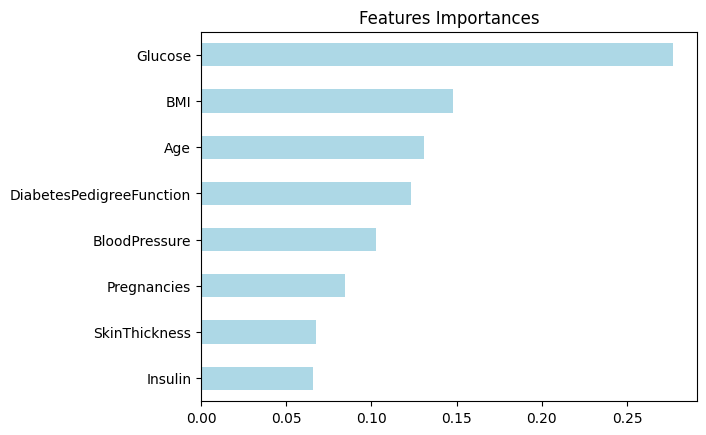

In [16]:
# Create a pd.Series of features importances
importances = pd.Series(data=clf.feature_importances_,
                        index= Xtrain.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(color='lightblue', kind='barh')
plt.title('Features Importances')
plt.show()


### Boosting

You can try to cross-validate some of the hyper parameters of this model, as it has been done for the regression model.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor


We can perform the boosting as it has been done for bagging.

In [2]:
# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate ada
ada = AdaBoostClassifier(estimator=dt, n_estimators=180, random_state=1)

# Fit ada to the training set
ada.fit(Xtrain, ytrain)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(Xtest)[:,1]

# Import roc_auc_score
#from sklearn.metrics import roc_auc_score

# Evaluate test-set roc_auc_score
# you can change and evaluate the accuracy score
ada_roc_auc = roc_auc_score(ytest, y_pred_proba)
# We can laso perform the accuracy

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

NameError: name 'DecisionTreeClassifier' is not defined